# Inception

### Kaggle score: --

### References:
1. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import gc

import cv2

### Run name

In [3]:
project_name = 'Digit_Recognizer'
step_name = 'Inception'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: Digit_Recognizer_Inception_20180115_183331


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\ref\Kaggle\digit-recognizer\input
log_path: D:\ref\Kaggle\digit-recognizer\log
model_path: D:\ref\Kaggle\digit-recognizer\model
output_path: D:\ref\Kaggle\digit-recognizer\output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

In [6]:
def show_data_images(rows, fig_column, y_data, *args):
    columns = len(args)
    figs, axes = plt.subplots(rows, columns, figsize=(rows, fig_column*columns))
    print(axes.shape)  
    for i, ax in enumerate(axes):
        y_data_str = ''
        if type(y_data) != type(None):
            y_data_str =  '_' + str(y_data[i])
        ax[0].set_title('28x28' + y_data_str)
        for j, arg in enumerate(args):
            ax[j].imshow(arg[i])

### Load data

In [7]:
train_file = os.path.join(input_path, 'train.csv')
test_file = os.path.join(input_path, 'test.csv')

In [8]:
%%time
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_data = raw_data[:,1:]
y_data = raw_data[:,0]

x_test = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')

describe(x_data)
describe(y_data)
describe(x_test)

(42000, 784) 0 255 112
(42000,) 0 9 96
(28000, 784) 0 255 112
Wall time: 27.9 s


In [9]:
x_data = x_data/255.
x_test = x_test/255.

describe(x_data)
describe(x_test)

x_data = x_data.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

describe(x_data)
describe(x_test)

(42000, 784) 0.0 1.0 263424112
(28000, 784) 0.0 1.0 175616112
(42000, 28, 28, 1) 0.0 1.0 144
(28000, 28, 28, 1) 0.0 1.0 144


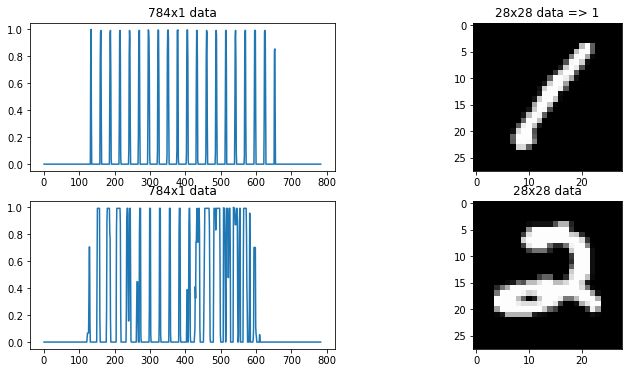

In [10]:
index = 0
fig, ax = plt.subplots(2, 2, figsize=(12,6))
ax[0, 0].plot(x_data[index].reshape(784,))
ax[0, 0].set_title('784x1 data')
ax[0, 1].imshow(x_data[index].reshape(28,28), cmap='gray')
ax[0, 1].set_title('28x28 data => ' + str(y_data[index]))
                 
ax[1, 0].plot(x_test[index].reshape(784,))
ax[1, 0].set_title('784x1 data')
ax[1, 1].imshow(x_test[index].reshape(28,28), cmap='gray')
ax[1, 1].set_title('28x28 data')

In [11]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
print(y_data[0])
y_data = to_categorical(y_data)
#example:
print(y_data[0])

Using TensorFlow backend.


1
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.05, random_state=2017)
describe(x_train)
describe(x_val)
describe(y_train)
describe(y_val)

(39900, 28, 28, 1) 0.0 1.0 250252944
(2100, 28, 28, 1) 0.0 1.0 13171344
(39900, 10) 0.0 1.0 3192112
(2100, 10) 0.0 1.0 168112


### Build model

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

In [14]:
def build_model():
    bn_model = 0
    p_activation = "relu"
    input_1 = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name="input")
    
    img_1 = Conv2D(128, kernel_size = (1,1), activation=p_activation, padding='same')(input_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2), padding='same') (img_1)
    img_1 = Dropout(0.25)(img_1)

    img_3 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same')(input_1)
    img_3 = BatchNormalization()(img_3)
    img_3 = AveragePooling2D((2,2), padding='same') (img_3)
    img_3 = Dropout(0.25)(img_3)
    
    img_5 = Conv2D(128, kernel_size = (5,5), activation=p_activation, padding='same')(input_1)
    img_5 = BatchNormalization()(img_5)
    img_5 = AveragePooling2D((2,2), padding='same') (img_5)
    img_5 = Dropout(0.25)(img_5)
    
    img_9 = Conv2D(128, kernel_size = (9,9), activation=p_activation, padding='same')(input_1)
    img_9 = BatchNormalization()(img_9)
    img_9 = AveragePooling2D((2,2), padding='same') (img_9)
    img_9 = Dropout(0.25)(img_9)

    concat_layer = (Concatenate()([img_1, img_3, img_5, img_9]))
#############################################################################################
    img_1 = Conv2D(128, kernel_size = (1,1), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2), padding='same') (img_1)
    img_1 = Dropout(0.25)(img_1)

    img_3 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_3 = BatchNormalization()(img_3)
    img_3 = AveragePooling2D((2,2), padding='same') (img_3)
    img_3 = Dropout(0.25)(img_3)
    
    img_5 = Conv2D(128, kernel_size = (5,5), activation=p_activation, padding='same')(concat_layer)
    img_5 = BatchNormalization()(img_5)
    img_5 = AveragePooling2D((2,2), padding='same') (img_5)
    img_5 = Dropout(0.25)(img_5)
    
    img_5 = Conv2D(128, kernel_size = (5,5), activation=p_activation, padding='same')(concat_layer)
    img_5 = BatchNormalization()(img_5)
    img_5 = AveragePooling2D((2,2), padding='same') (img_5)
    img_5 = Dropout(0.25)(img_5)
    
    img_9 = Conv2D(128, kernel_size = (9,9), activation=p_activation, padding='same')(concat_layer)
    img_9 = BatchNormalization()(img_9)
    img_9 = AveragePooling2D((2,2), padding='same') (img_9)
    img_9 = Dropout(0.25)(img_9)

    concat_layer = (Concatenate()([img_1, img_3, img_5, img_9]))
#############################################################################################
    img_1 = Conv2D(128, kernel_size = (1,1), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2), padding='same') (img_1)
    img_1 = Dropout(0.25)(img_1)

    img_3 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_3 = BatchNormalization()(img_3)
    img_3 = AveragePooling2D((2,2), padding='same') (img_3)
    img_3 = Dropout(0.25)(img_3)
    
    img_5 = Conv2D(128, kernel_size = (5,5), activation=p_activation, padding='same')(concat_layer)
    img_5 = BatchNormalization()(img_5)
    img_5 = AveragePooling2D((2,2), padding='same') (img_5)
    img_5 = Dropout(0.25)(img_5)
    
    img_9 = Conv2D(128, kernel_size = (9,9), activation=p_activation, padding='same')(concat_layer)
    img_9 = BatchNormalization()(img_9)
    img_9 = AveragePooling2D((2,2), padding='same') (img_9)
    img_9 = Dropout(0.25)(img_9)

    concat_layer = (Concatenate()([img_1, img_3, img_5, img_9]))
#############################################################################################
    img_1 = Conv2D(256, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(256, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(256, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2)) (img_1)
    img_1 = Dropout(0.25)(img_1)
#############################################################################################
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2)) (img_1)
    img_1 = Dropout(0.25)(img_1)
#############################################################################################

    img_1 = GlobalAveragePooling2D() (img_1)

    dense_ayer = Dense(4096, activation=p_activation)(img_1)
#     dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.25)(dense_ayer)
    dense_ayer = Dense(4096, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.25)(dense_ayer)
    dense_ayer = Dense(128, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.25)(dense_ayer)
    output = Dense(10, activation='softmax')(dense_ayer)

    model = Model(input_1, output)
    
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
    return model

In [15]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  256         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  1280        input[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 128)  3328        input[0][0]                      
__________________________________________________________________________________________________
conv2d_4 (

In [16]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [17]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** x)

# def get_lr(x):
#     lr = round(1e-4 * 0.995 ** x, 6)
#     if lr < 5e-5:
#         lr = 5e-5
#     print(lr, end='  ')
#     return lr
# annealer = LearningRateScheduler(get_lr)

# log_dir = os.path.join(log_path, run_name)
# print('log_dir:' + log_dir)
# tensorBoard = TensorBoard(log_dir=log_dir)

callbacks = [annealer]

In [18]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    rotation_range = 20,
    height_shift_range = 0.1,
    width_shift_range = 0.3
)

val_datagen = ImageDataGenerator()

In [19]:
%%time
batch_size = 128
steps_per_epoch = x_train.shape[0] / batch_size
hist = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size, seed=2018),
    steps_per_epoch=steps_per_epoch,
    epochs=400, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=callbacks,
    max_queue_size=256,
    workers=32,
    validation_steps=1000,
    validation_data=val_datagen.flow(x_val, y_val, batch_size=32, seed=2018)
)

Epoch 1/400
312/311 [==============================] - 85s 273ms/step - loss: 0.8017 - acc: 0.7404 - val_loss: 5.6823 - val_acc: 0.1881
Epoch 2/400
312/311 [==============================] - 81s 259ms/step - loss: 0.2636 - acc: 0.9387 - val_loss: 0.6764 - val_acc: 0.8319
Epoch 3/400
312/311 [==============================] - 81s 259ms/step - loss: 0.1806 - acc: 0.9579 - val_loss: 0.2421 - val_acc: 0.9600
Epoch 4/400
312/311 [==============================] - 81s 259ms/step - loss: 0.1464 - acc: 0.9653 - val_loss: 0.0486 - val_acc: 0.9905
Epoch 5/400
312/311 [==============================] - 81s 260ms/step - loss: 0.1392 - acc: 0.9690 - val_loss: 0.1384 - val_acc: 0.9762
Epoch 6/400
312/311 [==============================] - 81s 259ms/step - loss: 0.1173 - acc: 0.9735 - val_loss: 0.0949 - val_acc: 0.9819
Epoch 7/400
312/311 [==============================] - 81s 260ms/step - loss: 0.1135 - acc: 0.9745 - val_loss: 0.0497 - val_acc: 0.9890
Epoch 8/400
312/311 [===========================

Epoch 61/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0318 - acc: 0.9926 - val_loss: 0.0472 - val_acc: 0.9938
Epoch 62/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0345 - acc: 0.9918 - val_loss: 0.0304 - val_acc: 0.9943
Epoch 63/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0318 - acc: 0.9932 - val_loss: 0.0295 - val_acc: 0.9933
Epoch 64/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0327 - acc: 0.9926 - val_loss: 0.0364 - val_acc: 0.9952
Epoch 65/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0284 - acc: 0.9932 - val_loss: 0.0319 - val_acc: 0.9948
Epoch 66/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0302 - acc: 0.9924 - val_loss: 0.0304 - val_acc: 0.9943
Epoch 67/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0295 - acc: 0.9928 - val_loss: 0.0260 - val_acc: 0.9957
Epoch 68/400
312/311 [===================

312/311 [==============================] - 81s 260ms/step - loss: 0.0177 - acc: 0.9951 - val_loss: 0.0325 - val_acc: 0.9952
Epoch 121/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0190 - acc: 0.9954 - val_loss: 0.0381 - val_acc: 0.9948
Epoch 122/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0173 - acc: 0.9957 - val_loss: 0.0265 - val_acc: 0.9952
Epoch 123/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0159 - acc: 0.9961 - val_loss: 0.0367 - val_acc: 0.9948
Epoch 124/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0177 - acc: 0.9956 - val_loss: 0.0336 - val_acc: 0.9948
Epoch 125/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0165 - acc: 0.9958 - val_loss: 0.0383 - val_acc: 0.9957
Epoch 126/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0173 - acc: 0.9957 - val_loss: 0.0314 - val_acc: 0.9948
Epoch 127/400
312/311 [=========================

312/311 [==============================] - 81s 260ms/step - loss: 0.0119 - acc: 0.9970 - val_loss: 0.0452 - val_acc: 0.9948
Epoch 180/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0120 - acc: 0.9966 - val_loss: 0.0341 - val_acc: 0.9952
Epoch 181/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0111 - acc: 0.9971 - val_loss: 0.0375 - val_acc: 0.9948
Epoch 182/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0130 - acc: 0.9966 - val_loss: 0.0458 - val_acc: 0.9943
Epoch 183/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0125 - acc: 0.9969 - val_loss: 0.0297 - val_acc: 0.9952
Epoch 184/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0143 - acc: 0.9969 - val_loss: 0.0547 - val_acc: 0.9948
Epoch 185/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0140 - acc: 0.9965 - val_loss: 0.0344 - val_acc: 0.9948
Epoch 186/400
312/311 [=========================

312/311 [==============================] - 81s 260ms/step - loss: 0.0081 - acc: 0.9976 - val_loss: 0.0329 - val_acc: 0.9948
Epoch 239/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0095 - acc: 0.9972 - val_loss: 0.0283 - val_acc: 0.9957
Epoch 240/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0093 - acc: 0.9973 - val_loss: 0.0370 - val_acc: 0.9948
Epoch 241/400
312/311 [==============================] - 81s 259ms/step - loss: 0.0086 - acc: 0.9976 - val_loss: 0.0340 - val_acc: 0.9952
Epoch 242/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0072 - acc: 0.9980 - val_loss: 0.0443 - val_acc: 0.9933
Epoch 243/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0094 - acc: 0.9972 - val_loss: 0.0318 - val_acc: 0.9938
Epoch 244/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0113 - acc: 0.9973 - val_loss: 0.0345 - val_acc: 0.9948
Epoch 245/400
312/311 [=========================

312/311 [==============================] - 81s 260ms/step - loss: 0.0106 - acc: 0.9975 - val_loss: 0.0389 - val_acc: 0.9948
Epoch 298/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0077 - acc: 0.9981 - val_loss: 0.0419 - val_acc: 0.9943
Epoch 299/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0076 - acc: 0.9981 - val_loss: 0.0416 - val_acc: 0.9948
Epoch 300/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0374 - val_acc: 0.9943
Epoch 301/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0071 - acc: 0.9980 - val_loss: 0.0414 - val_acc: 0.9957
Epoch 302/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0073 - acc: 0.9980 - val_loss: 0.0351 - val_acc: 0.9957
Epoch 303/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0068 - acc: 0.9981 - val_loss: 0.0404 - val_acc: 0.9948
Epoch 304/400
312/311 [=========================

312/311 [==============================] - 81s 260ms/step - loss: 0.0080 - acc: 0.9981 - val_loss: 0.0306 - val_acc: 0.9957
Epoch 357/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0067 - acc: 0.9981 - val_loss: 0.0324 - val_acc: 0.9962
Epoch 358/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0065 - acc: 0.9983 - val_loss: 0.0307 - val_acc: 0.9957
Epoch 359/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0076 - acc: 0.9982 - val_loss: 0.0324 - val_acc: 0.9962
Epoch 360/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0080 - acc: 0.9979 - val_loss: 0.0350 - val_acc: 0.9957
Epoch 361/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0053 - acc: 0.9986 - val_loss: 0.0336 - val_acc: 0.9962
Epoch 362/400
312/311 [==============================] - 81s 260ms/step - loss: 0.0079 - acc: 0.9979 - val_loss: 0.0321 - val_acc: 0.9957
Epoch 363/400
312/311 [=========================

In [20]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0334, final accuracy: 0.9952


In [21]:
final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

Digit_Recognizer_Inception_20180115_183331_9952


In [22]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


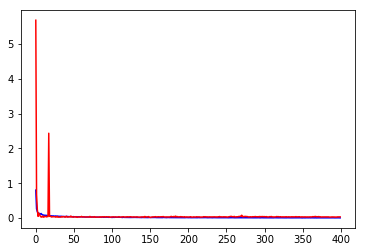

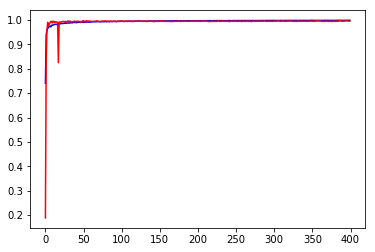

In [23]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [24]:
saveModel(model, run_name_acc)

In [25]:
# y_hat = model.predict(x_val)
# y_pred = np.argmax(y_hat, axis=1)
# y_true = np.argmax(y_val, axis=1)
# cm = confusion_matrix(y_true, y_pred)
# print(cm)

accuracy_score: 0.995238095238
[[201   0   0   0   0   0   0   0   0   0]
 [  0 235   0   0   0   0   0   1   1   0]
 [  0   0 229   0   0   0   0   0   0   0]
 [  0   0   0 219   0   0   0   0   0   0]
 [  0   0   0   0 211   0   0   0   0   2]
 [  0   0   0   1   0 164   0   0   1   0]
 [  1   0   0   0   0   0 215   0   0   0]
 [  0   0   0   0   0   0   0 230   0   0]
 [  0   0   0   0   0   0   0   0 195   2]
 [  0   0   0   0   1   0   0   0   0 191]]
count: 10
(10,)


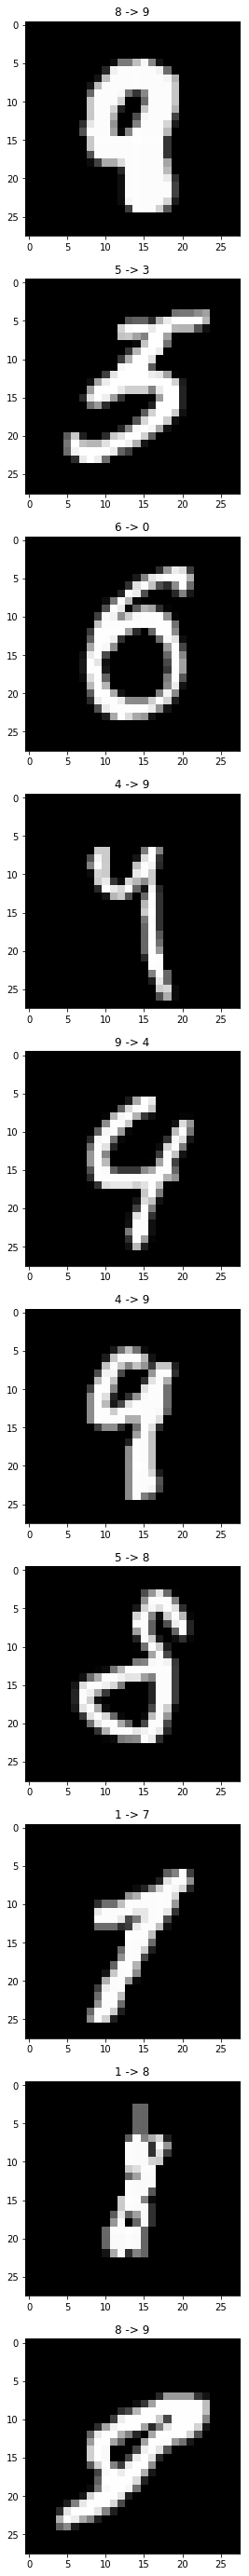

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score
def show_diffs(model, x_data, y_data, labels):
    y_hat = model.predict(x_data)
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_data, axis=1)
    print('accuracy_score: %s' % accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels)
    print(cm)
    indexes = []
    diffs = []
    for i, p in enumerate(zip(y_true, y_pred)):
        if p[0] != p[1]:
            indexes.append(i)
            diffs.append(p)
    count = len(indexes)
    print('count: %s' % count)
    figs, axes = plt.subplots(count, 1, figsize=(count,50))
    print(axes.shape)
    for i, p in enumerate(diffs):
        axes[i].imshow(x_val[indexes[i]].reshape(28, 28), cmap='gray')
        axes[i].set_title('%s -> %s' % (p[0], p[1]))
        
show_diffs(model, x_val, y_val, labels=list(range(0, 10)))

## Predict

In [27]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\ref\Kaggle\digit-recognizer\output\Digit_Recognizer_Inception_20180115_183331_9952.csv


In [28]:
y_hat = model.predict(x_test, batch_size=64)

In [29]:
y_pred = np.argmax(y_hat,axis=1)

In [30]:
with open(pred_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

In [31]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 32498.26 s
Done!


In [32]:
print(run_name_acc)

Digit_Recognizer_Inception_20180115_183331_9952
